![title](LogoEPL.jpg)
<b><p style='text-align: center;'> Algorithms in Data Science  </p> </b>

<b><p style='text-align: center;'> A network-based study </p> </b>
<b><p style='text-align: center;'> Anna Karenina, a novel by the Russian author Leo Tolstoy </p> </b>
<b><p style='text-align: center;'> Node embedding and k-means clustering </p> </b>

<i><p style='text-align: Center;'> Nima Farnoodian , Charles Rongione, Breno Tiburico</p> </i>


In [2]:
from networkx import *
import community 
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from math import (ceil, floor)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors 
import time
import random
import sklearn.metrics as mt
import re
from nameparser.parser import HumanName
from node2vec import Node2Vec
from sklearn.metrics import jaccard_score
import pandas as pd
from sklearn import decomposition
import itertools 
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm   # progress bar

In [3]:
def float_round(num, places = 0, direction = floor):
    return direction(num * (10**places)) / float(10**places)

In [4]:
def name_correct(text):
    text=text.split()
    text=[i.lower().capitalize() for i in text]
    name=' '.join(i for i in text)
    return name

In [5]:
def get_name(name):
    extractedRelation={}
    TITLE = r"(?:[A-Z][a-z]*\.\s*)?"
    NAME1 = r"[A-Z][a-z]+,?\s+"
    MIDDLE_I = r"(?:[A-Z][a-z]*\.?\s*)?"
    NAME2 = r"[A-Z][a-z]+"
    #result=re.findall(TITLE + NAME1 + MIDDLE_I + NAME2, name)
    Fullname = HumanName(name)
    #print(name)
    if Fullname['middle']!='':
        returnName=[Fullname['first'],Fullname['middle'],Fullname['last']]
    else:
        returnName=[Fullname['first'],Fullname['last']]
    return returnName

In [6]:
f=open('Charecters.txt')
file=f.readlines()
allnames={}
for name_Uncorrect in file[1:]:
    Name_role=name_Uncorrect.split(',')
    #print(Name_role)
    role=Name_role[1]
    name=Name_role[0].split('/') 
    name_corrected=name_correct(name[0])
    #print(name_corrected)
    DetailName=get_name(name_corrected)
    if len(name)>1:
        Alias=name_correct(name[1])
        if Alias not in allnames:
            allnames[Alias]=[(name_corrected,role[:-2].strip())]
        
    for i in DetailName:
        if i!='':
            if i not in allnames:
                allnames[i]=[(name_corrected,role[:-2].strip())]
            else:
                allnames[i].append((name_corrected,role[:-2].strip()))


In [7]:
def find_most_relevant(word, index, result, allnames):
    findleft=False
    findright=False
    for i in allnames[word]:
        nameCandit=i[0]
        if index>0:
            if nameCandit.find(result[index-1])>=0:
                findleft=True
                
        if index<len(result)-1:
            if nameCandit.find(result[index+1])>=0:
                findright=True
        if findleft or findright:
            
            return nameCandit
            break
    if findleft==False or findright==False:
        for i in allnames[word]:
            nameCandit=i[0]
            desc=i[1]
            if index>0:
                if desc.find(result[index-1])>=0 or desc.find(result[index-1].lower())>=0:
                    findleft=True
            if index<len(result)-1:        
                if desc.find(result[index+1])>=0 or desc.find(result[index+1].lower())>=0:
                    findright=True
            if findleft or findright:
                return nameCandit
                break
    if findleft==False or findright==False:
        return False

In [8]:
# Loading Book
with open("Anna_Karenina.txt", "r", encoding='UTF-8') as input:
    file_separated = input.read().split("\n\n")  

In [9]:
len(file_separated)

7705

In [10]:
Paranames={}
counter=0
paraWife=[]
praraWord=0
paranameCounter=0
for para in file_separated:
    NAME = r"[A-Z][a-z]+"
    result=re.findall( NAME, para)
    parawords=[]
    for i in range(len(result)):
        word=result[i]
        if word in allnames:
            if len(allnames[word])==1:
                parawords.append(allnames[word][0][0])
            else:
                NameInterpreted=find_most_relevant(word,i , result, allnames)
                if NameInterpreted:
                    parawords.append(NameInterpreted)
                else: 
                    if word=='Anna': # Anna is the main character and is mentioned frequently 
                        parawords.append(allnames[word][0][0])
                    else:
                        parawords.append(allnames[word][0][0])
    
    parawords=list(set(parawords))
    if parawords!=[] and len(parawords)>1:
        praraWord+=len(para.split())
        Paranames[counter]=parawords
        paranameCounter+=len(parawords)
        if 'Wife'in parawords:
            paraWife.append(counter)
    counter+=1
                    
                

In [11]:
print('The number of paragraph: ' + str(counter))
print('The number of paragraph in which at least two charachters are mentioned: ' + str(len(Paranames)))
print('The average number of words in the paragraphs: ' + str(float_round(praraWord/len(Paranames),3)))
print('The average number of Names in the paragraphs: ' + str(float_round(paranameCounter/len(Paranames),3)))

The number of paragraph: 7705
The number of paragraph in which at least two charachters are mentioned: 1561
The average number of words in the paragraphs: 87.427
The average number of Names in the paragraphs: 2.417


In [12]:
f=open('ParagraphName.txt','w+')
for i in Paranames:
    text=','.join(Paranames[i])
    text=text+'\n'
    f.write(text)
f.close()

In [13]:
adjL={}
namelist=[]
for i in Paranames:
    namelist+=Paranames[i]               

In [14]:
f=open('Charecters - Sex.txt')
Name_sexList=f.readlines()
Sex={}
for name in Name_sexList:
    name=name.split(',') 
    if name_correct(name[0]) in namelist:
        if name[1][:-1].strip()=='F':
            Sex[name_correct(name[0])]=0
        else:
            Sex[name_correct(name[0])]=1

In [15]:
f=open('ParagraphName.txt')
allNodes=f.readlines()
Nodes=[]
#Network_dict={}
for line in allNodes:
    line=line[:-1]
    Names=line.split(',')
    for name in Names:
        #print(name)
        Nodes.append(name)
Nodes=list(set(Nodes))

In [16]:
G = nx.Graph()
G.add_nodes_from(Nodes)
for node in G:
    #print(G.node[node])
    G.nodes[node]['Sex']=Sex[node]
f=open('ParagraphName.txt')
allNodes=f.readlines()
for line in allNodes:
    line=line[:-1]
    Names=line.split(',')
    for name in Names:
        copy_name=Names.copy()
        copy_name.pop(copy_name.index(name))
        for copy in copy_name:
            if copy not in G[name]:
                G.add_edge(name,copy,  weight=1)
            else:
                G[name][copy]["weight"]+=1
                #Network_dict[name].append(copy)


In [17]:
G["Varya"]

AtlasView({'Alexey Alexandrovitch Karenin': {'weight': 6}, 'Captain Yashvin': {'weight': 2}, 'Anna Arkadyevna Karenin': {'weight': 6}, 'Count Alexey Kirillovitch Vronsky': {'weight': 4}, 'Madame Karenina': {'weight': 2}, 'Countess Vronsky': {'weight': 6}, 'Princess Betsy Tverskoy': {'weight': 2}})

In [18]:
## Writing the network G into a csv file. It is an edge list representation of the network with weight.
# The edge for two actors x and y with weight z is shown as  x,y,z
f=open('edge_list_Anna.csv','w+')
for i in G: 
    n=list(G[i])
    for j in n:
        #print(i+','+j)
        f.write(i+','+j+','+str(G[i][j]['weight'])+'\n')
f.close()

In [19]:
# Write .gexf file for gephi.
nx.write_gexf(G, "Anna Karenina.gexf")

In [19]:
### Loading Network

In [29]:
G=read_gexf("Anna Karenina.gexf")

In [20]:
G['Anna Arkadyevna Karenin']

AtlasView({'Princess Darya Alexandrovna': {'weight': 224}, 'Alexey Alexandrovitch Karenin': {'weight': 188}, 'Prince Stepan Arkadyevitch Oblonsky': {'weight': 70}, 'Grisha': {'weight': 2}, 'Sergey': {'weight': 30}, 'Tanya': {'weight': 6}, 'Princess Ekaterina Alexandrovna Shtcherbatsky': {'weight': 76}, 'Count Alexey Kirillovitch Vronsky': {'weight': 286}, 'Countess Vronsky': {'weight': 54}, 'Konstantin Dmitrievitch Levin': {'weight': 36}, 'Yegorushka Korsunsky': {'weight': 18}, 'Countess Nordston': {'weight': 2}, 'Countess Lidia Ivanovna': {'weight': 30}, 'Princess Betsy Tverskoy': {'weight': 84}, 'Madame Karenina': {'weight': 20}, 'Baroness Shilton': {'weight': 2}, 'Captain Yashvin': {'weight': 18}, 'Varya': {'weight': 6}, 'Prince Alexander Shtcherbatsky': {'weight': 2}, 'Golenishtchev': {'weight': 36}, 'Mihailov': {'weight': 22}, 'Princess Varvara': {'weight': 30}, 'Vassenka Veslovsky': {'weight': 40}, 'Varvara Andreevna': {'weight': 2}, 'Princess Natalia': {'weight': 2}, 'Sergey Iva

In [26]:
G['Anna Arkadyevna Karenin']['Nikolay Levin']['weight']

4

In [31]:
CL=clustering(G,weight='weight')

In [38]:
deg=dict(G.degree(weight='weight'))
CLSorted=sorted(CL.items(), key=lambda item: item[1], reverse=True)
print ('Six characters with the highest weighted clustering coefficient:' )
highCluster=[]
for i in range(6):
    print(CLSorted[i][0]+': ' + str(float_round(CLSorted[i][1],3))+ ' /Degree: ' + str(deg[CLSorted[i][0]]) )
    highCluster.append(CLSorted[i][0])
print('\n')
print('Average weighted Clustering Coefficient: '+ str(float_round(average_clustering(G,weight='weight'),3)))

Six characters with the highest weighted clustering coefficient:
Golenishtchev: 0.074 /Degree: 146
Vassenka Veslovsky: 0.054 /Degree: 322
Nikolay Ivanovitch Sviazhsky: 0.045 /Degree: 294
Agafea Mihalovna: 0.043 /Degree: 112
Count Alexey Kirillovitch Vronsky: 0.042 /Degree: 1232
Konstantin Dmitrievitch Levin: 0.041 /Degree: 1748


Average weighted Clustering Coefficient: 0.032


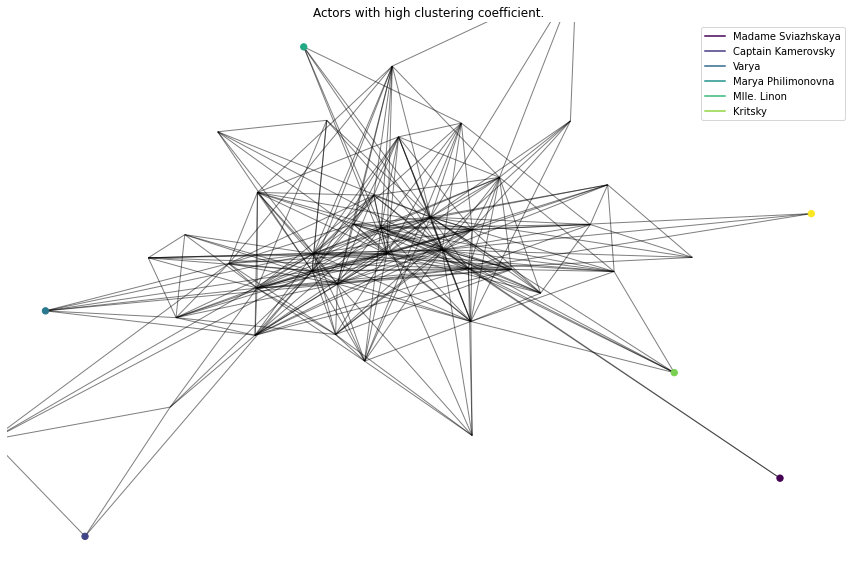

In [29]:
# Using a figure to use it as a parameter when calling nx.draw_networkx
HighCluster_Dict={}
Node_ID=0
for node in G:
    if node in highCluster:
        HighCluster_Dict[node]=Node_ID
        Node_ID+=1

jet = cm = plt.get_cmap('viridis')
cNorm  = colors.Normalize(vmin=0, vmax=max(HighCluster_Dict.values())+1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
for label in HighCluster_Dict:
    ax.plot([0],[0],
            color=scalarMap.to_rgba(HighCluster_Dict[label]),
            label=label)

pos = spring_layout(G) 
#print(list(HighCluster_Dict.values()))
#cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
draw_networkx_nodes(G, pos, HighCluster_Dict.keys(), node_size=40, 
                       node_color=list(HighCluster_Dict.values()),ax=ax)
draw_networkx_edges(G, pos, alpha=0.5)
''''''
plt.axis('off')
f.set_facecolor('w')

plt.legend(loc='best')
plt.title('Actors with high clustering coefficient.')

f.tight_layout()

plt.show()

In [31]:
deg=dict(G.degree(weight='weight'))
deg=sorted(deg.items(), key=lambda item: item[1], reverse=True)
print ('Six high-degree (weighted) characters:' )
highdegree=[]
for i in range(6):
    print(deg[i][0]+': ' + str(deg[i][1]))
    highdegree.append(deg[i][0])
print('\n')
degrees = G.degree()
j=0
for i in deg:
    j+=i[1]
print('Average Degree: ' +str(float_round(j/len(G), 3) ))

Six high-degree (weighted) characters:
Konstantin Dmitrievitch Levin: 1748
Anna Arkadyevna Karenin: 1318
Count Alexey Kirillovitch Vronsky: 1232
Princess Ekaterina Alexandrovna Shtcherbatsky: 1154
Prince Stepan Arkadyevitch Oblonsky: 1054
Princess Darya Alexandrovna: 910


Average Degree: 285.909


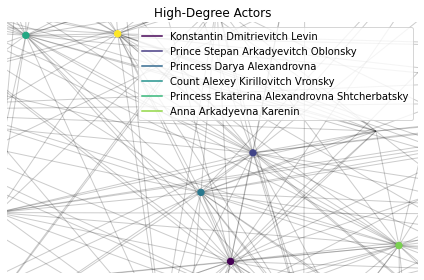

In [32]:
# Using a figure to use it as a parameter when calling nx.draw_networkx
High_Dict={}
Node_ID=0
for node in G:
    if node in highdegree:
        High_Dict[node]=Node_ID
        Node_ID+=1

jet = cm = plt.get_cmap('viridis')
cNorm  = colors.Normalize(vmin=0, vmax=max(High_Dict.values())+1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in High_Dict:
    ax.plot([0],[0],
            color=scalarMap.to_rgba(High_Dict[label]),
            label=label)

pos = spring_layout(G) 
#print(list(HighCluster_Dict.values()))
#cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
draw_networkx_nodes(G, pos, High_Dict.keys(), node_size=40, 
                       node_color=list(High_Dict.values()),ax=ax)
draw_networkx_edges(G, pos, alpha=0.2)
''''''
plt.axis('off')
f.set_facecolor('w')

plt.legend(loc='best')
plt.title('High-Degree Actors')

f.tight_layout()

plt.show()

In [33]:
print('Degree Assortativity Coefficient: '+ str( float_round(degree_assortativity_coefficient(G,weight='weight'),3)))

Degree Assortativity Coefficient: -0.234


In [34]:
print( 'The network has ' + str(number_connected_components(G)) + ' Connected Component(s)')

The network has 1 Connected Component(s)


In [35]:
print( 'Is the network directed? ' + str(G.is_directed()))

Is the network directed? False


In [36]:
print('Is the network multigraph? ' + str(G.is_multigraph()))

Is the network multigraph? False


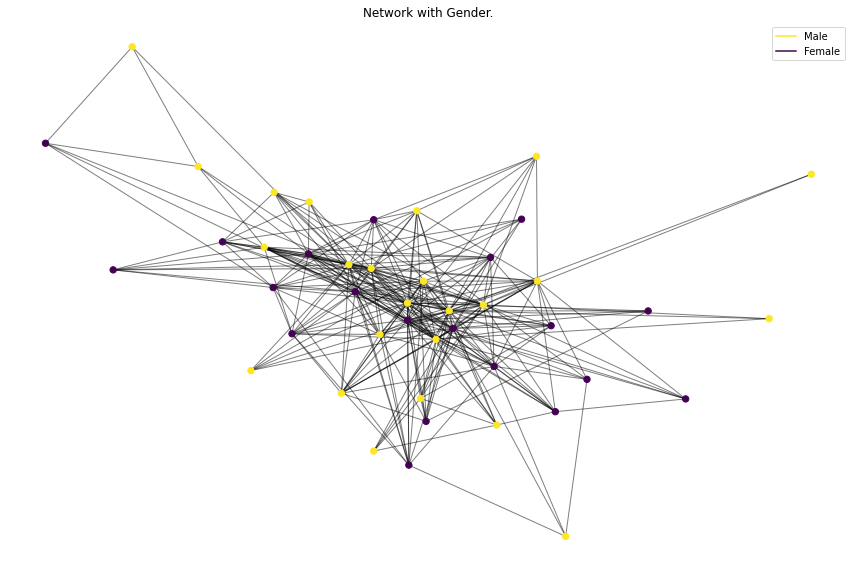

In [37]:
# Using a figure to use it as a parameter when calling nx.draw_networkx
Gender={'Male':1,'Female':0}

jet = cm = plt.get_cmap('viridis')
cNorm  = colors.Normalize(vmin=0, vmax=max(Gender.values()))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
for label in Gender:
    ax.plot([0],[0],
            color=scalarMap.to_rgba(Gender[label]),
            label=label)

pos = spring_layout(G) 
#print(list(HighCluster_Dict.values()))
#cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
draw_networkx_nodes(G, pos, Sex.keys(), node_size=40, 
                       node_color=list(Sex.values()),ax=ax)
draw_networkx_edges(G, pos, alpha=0.5)
''''''
plt.axis('off')
f.set_facecolor('w')

plt.legend(loc='best')
plt.title('Network with Gender.')

f.tight_layout()
plt.savefig('Gender-Based.png')
plt.show()

In [38]:
print('Modularity for Gender: ' +str(float_round(community.modularity(Sex, G, weight='weight'),3)))

Modularity for Gender: 0.025


In [39]:
partition = community.best_partition(G)


In [40]:
communityNumbers=len(set(partition.values()))
print('The network includes ' + str(communityNumbers) + ' communities')

The network includes 3 communities


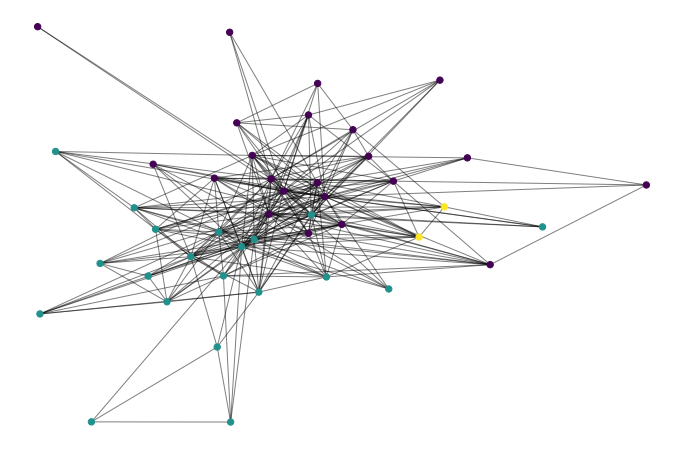

In [41]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
pos = spring_layout(G) 

cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
draw_networkx_nodes(G, pos, partition.keys(), node_size=40, 
                       cmap=cmap, node_color=list(partition.values()),ax=ax)
draw_networkx_edges(G, pos, alpha=0.5)
#f.tight_layout()
plt.axis('off')
f.set_facecolor('w')
plt.savefig('Communities.png')
plt.show()

In [42]:
print('Modularity fro partitions: ' +str(community.modularity(partition, G, weight='weight')))

Modularity fro partitions: 0.24763303095483025


In [71]:
partition

{'Konstantin Dmitrievitch Levin': 0,
 'Marya Nikolaevna': 0,
 'Madame Sviazhskaya': 0,
 'Captain Kamerovsky': 1,
 'Countess Vronsky': 1,
 'Baroness Shilton': 1,
 'Princess Betsy Tverskoy': 1,
 'Tanya': 2,
 'Varya': 1,
 'Professor Katavasov': 0,
 'Countess Lidia Ivanovna': 1,
 'Lieutenant Petritsky': 1,
 'Captain Yashvin': 1,
 'Prince Alexander Shtcherbatsky': 0,
 'Prince Stepan Arkadyevitch Oblonsky': 0,
 'Alexey Alexandrovitch Karenin': 1,
 'Yegorushka Korsunsky': 1,
 'Agafea Mihalovna': 0,
 'Princess Darya Alexandrovna': 1,
 'Sergey Ivanovitch Koznishev': 0,
 'Arseny Lvov': 0,
 'Marya Philimonovna': 1,
 'Count Alexey Kirillovitch Vronsky': 1,
 'Sergey': 1,
 'Princess Ekaterina Alexandrovna Shtcherbatsky': 0,
 'Madame Stahl': 0,
 'Varvara Andreevna': 0,
 'Petrov': 0,
 'Princess Varvara': 1,
 'Professor Metrov': 0,
 'Countess Nordston': 0,
 'Nikolay Ivanovitch Sviazhsky': 0,
 'Golenishtchev': 1,
 'Madame Karenina': 1,
 'Vassenka Veslovsky': 0,
 'Mlle. Linon': 0,
 'Kritsky': 0,
 'Anna P

# Node2Vec

To install node2vec, use pip install node2vec. Go to https://github.com/eliorc/node2vec for details.

In [228]:
node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=200, workers=4,weight_key='weight')  # Use temp_folder for big graphs


Computing transition probabilities: 100%|████████████████████████████████████████████| 44/44 [00:00<00:00, 1100.14it/s]


In [229]:
model = node2vec.fit(window=15, min_count=1, batch_words=8) 

In [230]:
model.wv.most_similar('Anna Arkadyevna Karenin')

[('Princess Betsy Tverskoy', 0.8905969262123108),
 ('Varya', 0.8703762292861938),
 ('Madame Karenina', 0.8702288269996643),
 ('Princess Varvara', 0.8310012221336365),
 ('Alexey Alexandrovitch Karenin', 0.7959307432174683),
 ('Countess Vronsky', 0.7627233266830444),
 ('Countess Lidia Ivanovna', 0.6720829010009766),
 ('Count Alexey Kirillovitch Vronsky', 0.6630701422691345),
 ('Sergey', 0.6310915946960449),
 ('Golenishtchev', 0.6304739713668823)]

In [231]:
model.wv.save_word2vec_format('N2V.txt')


In [232]:
model.save('Anna Karenina.md')

In [233]:
model.wv['Anna Arkadyevna Karenin']

array([ 0.00950134, -0.33200747, -0.29341385, -0.02732701,  0.29827592,
        0.04934352, -0.09851481,  0.00558019, -0.19496402, -0.02968612,
       -0.1642576 ,  0.18187758,  0.15077049, -0.05751868,  0.06113125,
       -0.04562753,  0.29169264,  0.00089218,  0.02820789, -0.25197938,
        0.0868561 , -0.0978915 , -0.09020112,  0.0036372 , -0.02817112,
       -0.3444678 , -0.0875366 , -0.24013491,  0.12074896, -0.01586377,
        0.24361266,  0.14588568,  0.04509511,  0.04526743,  0.18306862,
       -0.08403757,  0.00286907,  0.23608857,  0.08402643,  0.02892208,
        0.1897718 ,  0.13670547, -0.1585115 , -0.06235819,  0.02093577,
       -0.01103879,  0.08192353,  0.05799084, -0.08742379, -0.08425079,
       -0.1216592 , -0.03006659, -0.14010657,  0.23133183,  0.05244443,
        0.18223166, -0.18578492, -0.04423347, -0.09829905,  0.21518694,
        0.00111523, -0.3082606 ,  0.04493381, -0.47503763, -0.05698361,
        0.21892738, -0.17044958,  0.172959  ,  0.3221876 ,  0.13

In [234]:
# Returning the word vector for a node
def vec(s,model):
    return model.wv[s]

In [237]:
name=[str(i) for i in range (p.shape[0])]
name=['Actor','Louvain','K-mean']+name


In [238]:
node2vector=pd.DataFrame(data=None, index=None, columns=name) 

In [240]:
counter=0
for i in G:
    node2vector.loc[str(counter)]=[i]+[partition[i]]+[0]+list(vec(i,model))
    counter+=1

In [242]:
X_for_Kmeans=node2vector.iloc[:,3:].to_numpy()

## K-means Clustering using NLTK

In [243]:

# desired number of clusters to find
NUM_CLUSTERS=communityNumbers

# Sparial clustering with k-means

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance= nltk.cluster.util.cosine_distance, repeats=10)

# be careful to supply the original vectors to the algorithm!
assigned_clusters = kclusterer.cluster(X_for_Kmeans, assign_clusters=True)


In [244]:
node2vector['K-mean']=assigned_clusters

###  Jaccard Similarity 

In [245]:

def jaccard(labels1, labels2):
    """
    Computes the Jaccard similarity between two sets of clustering labels.
    The value returned is between 0 and 1, inclusively. A value of 1 indicates
    perfect agreement between two clustering algorithms, whereas a value of 0
    indicates no agreement. For details on the Jaccard index, see:
    http://en.wikipedia.org/wiki/Jaccard_index
    Example:
    labels1 = [1, 2, 2, 3]
    labels2 = [3, 4, 4, 4]
    print jaccard(labels1, labels2)
    @param labels1 iterable of cluster labels
    @param labels2 iterable of cluster labels
    @return the Jaccard similarity value
    """
    n11 = n10 = n01 = 0
    n = len(labels1)
    # TODO: Throw exception if len(labels1) != len(labels2)
    for i, j in itertools.combinations(range(n), 2):
        comembership1 = labels1[i] == labels1[j]
        comembership2 = labels2[i] == labels2[j]
        if comembership1 and comembership2:
            n11 += 1
        elif comembership1 and not comembership2:
            n10 += 1
        elif not comembership1 and comembership2:
            n01 += 1
    return float(n11) / (n11 + n10 + n01)

In [246]:
result=jaccard(list(node2vector['Louvain']), list(node2vector['K-mean']))
print('Jaccard Similarity: ' + str(float_round(result,3)))

Jaccard Similarity: 0.808


###  Normalized Mutual Information

In [247]:
result3=mt.normalized_mutual_info_score(list(node2vector['Louvain']),list(node2vector['K-mean']))
print('Normalized Mutual Information: ' + str(float_round(result3,3)))

Normalized Mutual Information: 0.77


###  Modularity



In [259]:
partition_kmeans={}
for i in range(len(df_best)):
    partition_kmeans[node2vector.iloc[i,0]]=node2vector.iloc[i,2]
print('Modularity for the clusters found by kmeans (The clusters with the Jaccard score ' + str(float_round(result,3))+') : ' +str(float_round(community.modularity(partition_kmeans, G, weight='weight'),3)))

Modularity for the clusters found by kmeans (The clusters with the Jaccard score 0.808) : 0.232


In [260]:
node2vector.to_csv('Anna-Jaccard808.csv')

## K-mean Clustering with euclidean distance for better visualization

In [270]:
kmean=KMeans(n_clusters=communityNumbers,init='k-means++')
kmean.fit(node2vector.iloc[:,3:])

KMeans(n_clusters=3)

## PCA and TSNE analysis and plotting

In [272]:
pca = decomposition.PCA(n_components=2)
pca.fit(node2vector.iloc[:,3:])
X = pca.transform(node2vector.iloc[:,3:])

In [273]:
Coordinate_X_pca=[]
Coordinate_Y_pca=[]
for i in X:
    Coordinate_X_pca.append(i[0])
    Coordinate_Y_pca.append(i[1])

"\ncenters = kmean.cluster_centers_\nplt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);\n"

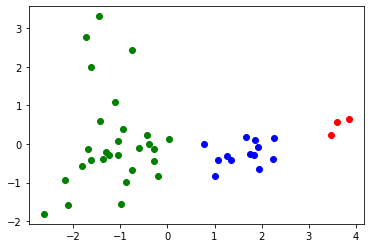

In [280]:
my_colors = {0:'red',1:'green',2:'blue'}

for i,j in enumerate(Coordinate_X_pca):
    # look for the color based on vocabulary, if not found in vocubulary, then black is returned.
    plt.scatter(Coordinate_X_pca[i] , Coordinate_Y_pca[i], color = my_colors.get(kmean.labels_[i], 'black'))


'''
centers = kmean.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
'''

In [71]:
from sklearn.manifold import TSNE
X_tsne = node2vector.iloc[:,3:]
X_embedded = TSNE(n_components=2).fit_transform(X_tsne)
X_embedded.shape
(4, 2)

(4, 2)

In [72]:
Coordinate_X=[]
Coordinate_Y=[]
for i in X_embedded:
    Coordinate_X.append(i[0])
    Coordinate_Y.append(i[1])

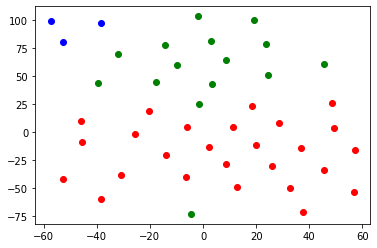

In [73]:
my_colors = {0:'red',1:'green',2:'blue'}

for i,j in enumerate(Coordinate_X):
    # look for the color based on vocabulary, if not found in vocubulary, then black is returned.
    plt.scatter(Coordinate_X[i] , Coordinate_Y[i], color = my_colors.get(kmean.labels_[i], 'black'))

## Finding best parameters and Bad parameters

In [4]:
Jaccard=[]
NMI_Score=[]
NUM_CLUSTERS=communityNumbers
walk_length=[10,20,30,40,50]
num_walk=[50,100,150,200]
workers=[4]
window=[5,40,15,20,25,30]
batch_word=[2,4,6,8,10,12,16]
best_score=0
bad_score=float('inf')
Best_Para={'walk_length':0,'num_walk':0,'worker':0,'window':0,'batch_word':0,'Best_jaccard_score':0,'Best_NMI_score':0}
Bad_Para={'walk_length':0,'num_walk':0,'worker':0,'window':0,'batch_word':0,'Bad_jaccard_score':0,'Bad_NMI_score':0}
for wl in walk_length:
    for nw in num_walk:
        for worker in workers:
            for w in window:
                for bw in batch_word:
                    try:
                        node2vec2 = Node2Vec(G, dimensions=128, walk_length=wl, num_walks=nw, workers=worker,weight_key='weight')  # Use temp_folder for big graphs
                        model2 = node2vec2.fit(window=w, min_count=1, batch_words=bw) 
                        X=get_x(128,model2)
                        kclusterer = KMeansClusterer(NUM_CLUSTERS, distance= nltk.cluster.util.cosine_distance, repeats=10)

                        # be careful to supply the original vectors to the algorithm!
                        assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
                        result=jaccard(list(node2vector['Louvain']), list(assigned_clusters))
                        Jaccard.append(result)
                        NMI=mt.normalized_mutual_info_score(list(node2vector['Louvain']),list(assigned_clusters))
                        NMI_Score.append(NMI)
                        if result>best_score:
                            best_score=result
                            model2.wv.save_word2vec_format('best_mode.txt')
                            Best_Para['walk_length']=wl
                            Best_Para['num_walk']=nw
                            Best_Para['worker']=worker
                            Best_Para['window']=w
                            Best_Para['batch_word']=bw
                            Best_Para['Best_jaccard_score']=best_score
                            Best_Para['Best_NMI_score']=NMI
                            print('Best Jaccard: ' + str(float_round(best_score,3)))
                        if result<bad_score:
                            bad_score=result
                            model2.wv.save_word2vec_format('bad_mode.txt')
                            Bad_Para['walk_length']=wl
                            Bad_Para['num_walk']=nw
                            Bad_Para['worker']=worker
                            Bad_Para['window']=w
                            Bad_Para['batch_word']=bw
                            Bad_Para['Bad_jaccard_score']=bad_score
                            Bad_Para['Bad_NMI_score']=NMI
                            print('Bad Jaccard: ' + str(float_round(bad_score,3)))
                    except:
                        pass

In [132]:
# this function is used to create WordMatrix, later used
def get_x(no,model2):
    name=[str(i) for i in range (no)]
    wordMatrix=pd.DataFrame(data=None, index=None, columns=name) 
    counter=0
    for i in G:
        wordMatrix.loc[str(counter)]=list(vec(i,model2))
        counter+=1
    wordMatrix=wordMatrix.to_numpy()
    return wordMatrix

In [125]:
walk_length=[10,20,30,40,50]
num_walk=[50,100,150,200]
workers=[1,2,3,4,5,6]
window=[5,40,15,20,25,30]
batch_word=[2,4,6,8,10,12,16]

In [137]:
Best_Para


{'walk_length': 10,
 'num_walk': 50,
 'worker': 5,
 'window': 25,
 'batch_word': 4,
 'Best_jaccard_score': 0.7755555555555556,
 'Best_NMI_score': 0.714080561150979}

In [174]:
Bad_Para

{'walk_length': 20,
 'num_walk': 50,
 'worker': 5,
 'window': 40,
 'batch_word': 2,
 'Bad_jaccard_score': 0.38786764705882354,
 'Bad_NMI_score': 0.433863788412178}

<b> Here, we plot the jaccard and normalized mutual information score for 1024 experiments with different parameters </b>

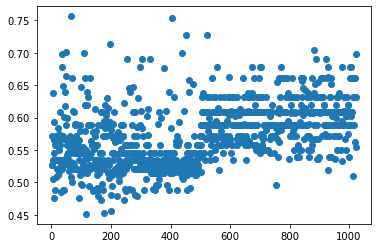

In [157]:
plt.scatter(np.linspace(1, len(NMI_Score[:1023]), num=len(NMI_Score[:1023])),NMI_Score[:1023])

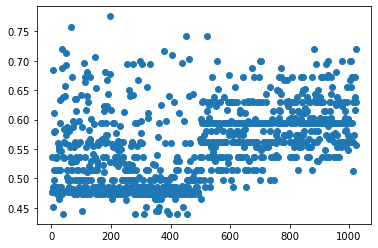

In [158]:
plt.scatter(np.linspace(1, len(NMI_Score[:1023]), num=len(NMI_Score[:1023])),Jaccard)

In [141]:
print(Jaccard[:1023])

[0.5360169491525424, 0.4778225806451613, 0.4778225806451613, 0.45219123505976094, 0.4857142857142857, 0.6837944664031621, 0.5783898305084746, 0.6108949416342413, 0.5144628099173554, 0.49793388429752067, 0.4857142857142857, 0.5146443514644351, 0.5811965811965812, 0.5352697095435685, 0.5360169491525424, 0.4857142857142857, 0.5360169491525424, 0.5146443514644351, 0.4857142857142857, 0.47410358565737054, 0.4785992217898833, 0.47410358565737054, 0.5610278372591007, 0.5529661016949152, 0.46464646464646464, 0.548728813559322, 0.514344262295082, 0.5934782608695652, 0.6338912133891214, 0.4857142857142857, 0.4778225806451613, 0.5471311475409836, 0.4857142857142857, 0.47410358565737054, 0.6883408071748879, 0.7194570135746606, 0.6387755102040816, 0.4778225806451613, 0.5360169491525424, 0.43992248062015504, 0.5627615062761506, 0.5842217484008528, 0.5352697095435685, 0.6565874730021598, 0.5842217484008528, 0.6401766004415012, 0.5594795539033457, 0.5735294117647058, 0.6929824561403509, 0.712719298245

## Best model obained using best parameters 

In [153]:
def ReadingVector(filename,partition,d):
    col=[str(i) for i in range (d)]
    col=['Actor','Louvain','K-mean']+col
    node2vector=pd.DataFrame(data=None, index=None, columns=col)
    f=open (filename,mode='r')
    alllines=f.readlines()
    cleanMatrix=[]
    counter=0
    for line in alllines:
        name=[]
        num=[]
        line=line[:-2].split(' ')
        for word in line:
            try:
            #if word.startswith('-') or word.startswith('0') :
                #print(word)
                num.append(float(word))
            #else:
            except:
                #print(word)
                name.append(word)
                
        name=' '.join(name)
        #vector= [name] 
        #vector+=num
        #cleanMatrix.append(vector)
        node2vector.loc[str(counter)]=[name]+[partition[name]]+[0]+num
        counter+=1
    return node2vector

In [154]:
df_best=ReadingVector('best_mode.txt',partition,128)

In [159]:
df_best.head()

,Actor,Louvain,K-mean,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
0,Konstantin Dmitrievitch Levin,0,1,-0.053376,0.064350,0.069892,0.144266,0.185172,-0.020155,-0.050357,...,-0.130118,-0.166370,-0.062427,-0.027374,-0.012822,-0.090709,-0.274598,0.021307,0.011041,0.027263
1,Anna Arkadyevna Karenin,1,2,-0.045048,0.051239,0.067579,0.153419,0.187778,-0.028638,-0.031455,...,-0.124117,-0.154836,-0.050029,-0.044358,0.010922,-0.073497,-0.274705,0.015005,0.038146,0.014501
2,Count Alexey Kirillovitch Vronsky,1,2,-0.049419,0.049349,0.066074,0.149311,0.191569,-0.022284,-0.035667,...,-0.128874,-0.161021,-0.048508,-0.038825,0.008364,-0.072915,-0.274282,0.023068,0.027922,0.021525
3,Princess Ekaterina Alexandrovna Shtcherbatsky,0,1,-0.059740,0.060144,0.071442,0.140952,0.186827,-0.023916,-0.046629,...,-0.134040,-0.172399,-0.068972,-0.026519,-0.006133,-0.090115,-0.274763,0.023332,0.008667,0.030873
4,Prince Stepan Arkadyevitch Oblonsky,0,0,-0.049911,0.057522,0.065030,0.139310,0.184679,-0.021609,-0.042907,...,-0.120308,-0.159618,-0.055109,-0.031577,-0.005471,-0.080489,-0.256093,0.015386,0.016441,0.019932


In [170]:
X_for_Kmeans_best=df_best.iloc[:,3:].to_numpy()

# desired number of clusters to find
NUM_CLUSTERS=communityNumbers

# Sparial clustering with k-means

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance= nltk.cluster.util.cosine_distance, repeats=10)

# be careful to supply the original vectors to the algorithm!
assigned_clusters = kclusterer.cluster(X_for_Kmeans_best, assign_clusters=True)
df_best['K-mean']=assigned_clusters

In [173]:
df_best.tail()

,Actor,Louvain,K-mean,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
39,Captain Kamerovsky,1,1,-0.048827,0.058769,0.070194,0.157691,0.194841,-0.025411,-0.045717,...,-0.136846,-0.176043,-0.056229,-0.040758,0.004348,-0.082463,-0.284770,0.023290,0.024014,0.024763
40,Marya Philimonovna,1,1,-0.047093,0.052171,0.064269,0.133113,0.177216,-0.023073,-0.037618,...,-0.121083,-0.153701,-0.055265,-0.032281,-0.002695,-0.071937,-0.253583,0.015839,0.021598,0.017744
41,Petrov,0,0,-0.054776,0.053580,0.067060,0.144321,0.189631,-0.024158,-0.046930,...,-0.132447,-0.164141,-0.059757,-0.031562,-0.001832,-0.083971,-0.275979,0.017616,0.013165,0.020807
42,Kritsky,0,0,-0.039899,0.047127,0.057449,0.118480,0.149490,-0.018602,-0.036154,...,-0.099685,-0.134893,-0.047962,-0.023336,-0.002986,-0.068818,-0.218263,0.017566,0.017570,0.017233
43,Madame Sviazhskaya,0,0,-0.046824,0.051579,0.056896,0.116667,0.156667,-0.020599,-0.038429,...,-0.107271,-0.135028,-0.046247,-0.026146,-0.000204,-0.070704,-0.224655,0.016635,0.014626,0.022117


In [264]:
result=jaccard(list(df_best['Louvain']), list(df_best['K-mean']))
print('Jaccard Similarity: ' + str(float_round(result,3)))

Jaccard Similarity: 0.775


In [265]:
result3=mt.normalized_mutual_info_score(list(df_best['Louvain']),list(df_best['K-mean']))
print('Normalized Mutual Information: ' + str(float_round(result3,3)))

Normalized Mutual Information: 0.714


In [266]:
partition_best={}
for i in range(len(df_best)):
    partition_best[df_best.iloc[i,0]]=df_best.iloc[i,2]
print('Modularity for the clusters found by kmeans (The clusters with the best Jaccard score) : ' +str(float_round(community.modularity(partition_best, G, weight='weight'),3)))

Modularity for the clusters found by kmeans (The clusters with the best Jaccard score) : 0.24


In [267]:
# Storing the Anna Data whose Jaccard score is 0.775
df_best.to_csv('Anna-Jaccard775.csv')

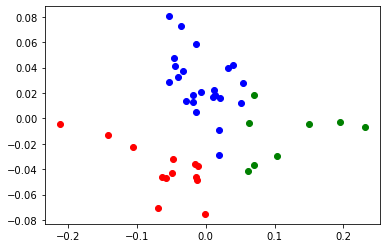

In [205]:
kmean=KMeans(n_clusters=communityNumbers,init='k-means++')
kmean.fit(df_best.iloc[:,3:])
pca = decomposition.PCA(n_components=2)
pca.fit(df_best.iloc[:,3:])

X = pca.transform(df_best.iloc[:,3:])

Coordinate_X_pca=[]
Coordinate_Y_pca=[]
for i in X:
    Coordinate_X_pca.append(i[0])
    Coordinate_Y_pca.append(i[1])
    
my_colors = {0:'red',1:'green',2:'blue'}

for i,j in enumerate(Coordinate_X_pca):
    # look for the color based on vocabulary, if not found in vocubulary, then black is returned.
    plt.scatter(Coordinate_X_pca[i] , Coordinate_Y_pca[i], color = my_colors.get(kmean.labels_[i], 'black'))

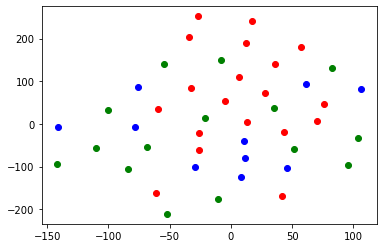

In [203]:
from sklearn.manifold import TSNE
X_tsne = df_best.iloc[:,3:]
X_embedded = TSNE(n_components=2).fit_transform(X_tsne)
X_embedded.shape

Coordinate_X=[]
Coordinate_Y=[]
for i in X_embedded:
    Coordinate_X.append(i[0])
    Coordinate_Y.append(i[1])
    
my_colors = {0:'red',1:'green',2:'blue'}

for i,j in enumerate(Coordinate_X):
    # look for the color based on vocabulary, if not found in vocubulary, then black is returned.
    plt.scatter(Coordinate_X[i] , Coordinate_Y[i], color = my_colors.get(kmean.labels_[i], 'black'))

## Worst model obained using worst parameters 

In [180]:
df_bad=ReadingVector('bad_mode.txt',partition,128)

In [181]:
df_best.head()

,Actor,Louvain,K-mean,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
0,Konstantin Dmitrievitch Levin,0,0,-0.053376,0.064350,0.069892,0.144266,0.185172,-0.020155,-0.050357,...,-0.130118,-0.166370,-0.062427,-0.027374,-0.012822,-0.090709,-0.274598,0.021307,0.011041,0.027263
1,Anna Arkadyevna Karenin,1,2,-0.045048,0.051239,0.067579,0.153419,0.187778,-0.028638,-0.031455,...,-0.124117,-0.154836,-0.050029,-0.044358,0.010922,-0.073497,-0.274705,0.015005,0.038146,0.014501
2,Count Alexey Kirillovitch Vronsky,1,2,-0.049419,0.049349,0.066074,0.149311,0.191569,-0.022284,-0.035667,...,-0.128874,-0.161021,-0.048508,-0.038825,0.008364,-0.072915,-0.274282,0.023068,0.027922,0.021525
3,Princess Ekaterina Alexandrovna Shtcherbatsky,0,0,-0.059740,0.060144,0.071442,0.140952,0.186827,-0.023916,-0.046629,...,-0.134040,-0.172399,-0.068972,-0.026519,-0.006133,-0.090115,-0.274763,0.023332,0.008667,0.030873
4,Prince Stepan Arkadyevitch Oblonsky,0,0,-0.049911,0.057522,0.065030,0.139310,0.184679,-0.021609,-0.042907,...,-0.120308,-0.159618,-0.055109,-0.031577,-0.005471,-0.080489,-0.256093,0.015386,0.016441,0.019932


In [182]:
X_for_Kmeans_bad=df_bad.iloc[:,3:].to_numpy()

# desired number of clusters to find
NUM_CLUSTERS=communityNumbers

# Sparial clustering with k-means

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance= nltk.cluster.util.cosine_distance, repeats=10)

# be careful to supply the original vectors to the algorithm!
assigned_clusters = kclusterer.cluster(X_for_Kmeans_bad, assign_clusters=True)
df_bad['K-mean']=assigned_clusters

In [184]:
df_bad.tail()

,Actor,Louvain,K-mean,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
39,Mlle. Linon,0,1,-0.066805,0.010319,0.082824,0.111792,0.221626,-0.055777,-0.065035,...,-0.124591,-0.233407,-0.120015,0.034061,-0.002561,-0.081899,-0.286412,0.012429,-0.025679,0.044121
40,Petrov,0,1,-0.072116,0.009531,0.086909,0.114222,0.222120,-0.059174,-0.075450,...,-0.133383,-0.232923,-0.120929,0.033897,0.000290,-0.086734,-0.296171,0.005663,-0.031547,0.037763
41,Captain Kamerovsky,1,1,-0.088206,-0.020834,0.110357,0.118042,0.198722,-0.080049,-0.057584,...,-0.116154,-0.208315,-0.074466,-0.009498,0.060405,-0.033355,-0.293843,-0.003501,0.050825,0.032573
42,Kritsky,0,1,-0.064397,0.012800,0.087274,0.111513,0.212246,-0.054352,-0.067153,...,-0.120728,-0.229072,-0.118590,0.036903,-0.000692,-0.084492,-0.281642,0.010562,-0.019819,0.040199
43,Madame Sviazhskaya,0,1,-0.064338,0.004487,0.079521,0.089399,0.174295,-0.053638,-0.053212,...,-0.101801,-0.178691,-0.082051,0.018976,0.018044,-0.056336,-0.237740,0.003660,0.003497,0.033508


In [185]:
result=jaccard(list(df_bad['Louvain']), list(df_bad['K-mean']))
print('Jaccard Similarity: ' + str(float_round(result,3)))

Jaccard Similarity: 0.387


In [224]:
nmibad=mt.normalized_mutual_info_score(list(df_bad['Louvain']),list(df_bad['K-mean']))
print('Normalized Mutual Information: ' + str(float_round(nmibad,3)))

Normalized Mutual Information: 0.433


In [262]:
partition_worst={}
for i in range(len(df_best)):
    partition_worst[df_bad.iloc[i,0]]=df_bad.iloc[i,2]
print('Modularity for the clusters found by kmeans (The clusters with the worst Jaccard score) : ' +str(float_round(community.modularity(partition_worst, G, weight='weight'),3)))

Modularity for the clusters found by kmeans (The clusters with the worst Jaccard score) : 0.202


In [263]:
# Storing the Anna Data whose Jaccard score is 0.387
df_bad.to_csv('Anna-Jaccard387.csv')

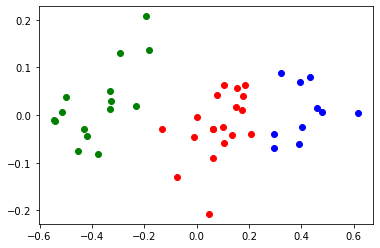

In [192]:
kmean=KMeans(n_clusters=communityNumbers,init='k-means++')
kmean.fit(df_bad.iloc[:,3:])
pca = decomposition.PCA(n_components=2)
pca.fit(df_bad.iloc[:,3:])

X = pca.transform(df_bad.iloc[:,3:])

Coordinate_X_pca=[]
Coordinate_Y_pca=[]
for i in X:
    Coordinate_X_pca.append(i[0])
    Coordinate_Y_pca.append(i[1])
    
my_colors = {0:'red',1:'green',2:'blue'}

for i,j in enumerate(Coordinate_X_pca):
    # look for the color based on vocabulary, if not found in vocubulary, then black is returned.
    plt.scatter(Coordinate_X_pca[i] , Coordinate_Y_pca[i], color = my_colors.get(kmean.labels_[i], 'black'))

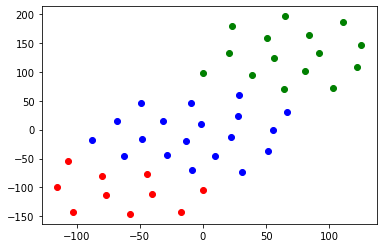

In [187]:
from sklearn.manifold import TSNE
X_tsne = df_bad.iloc[:,3:]
X_embedded = TSNE(n_components=2).fit_transform(X_tsne)
X_embedded.shape

Coordinate_X=[]
Coordinate_Y=[]
for i in X_embedded:
    Coordinate_X.append(i[0])
    Coordinate_Y.append(i[1])
    
my_colors = {0:'red',1:'green',2:'blue'}

for i,j in enumerate(Coordinate_X):
    # look for the color based on vocabulary, if not found in vocubulary, then black is returned.
    plt.scatter(Coordinate_X[i] , Coordinate_Y[i], color = my_colors.get(kmean.labels_[i], 'black'))

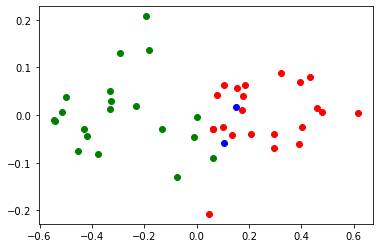

In [193]:
# Louvain the nodes colored based on the communities found by the Louvain algorithm
kmean=KMeans(n_clusters=communityNumbers,init='k-means++')
kmean.fit(df_bad.iloc[:,3:])
pca = decomposition.PCA(n_components=2)
pca.fit(df_bad.iloc[:,3:])

X = pca.transform(df_bad.iloc[:,3:])

Coordinate_X_pca=[]
Coordinate_Y_pca=[]
for i in X:
    Coordinate_X_pca.append(i[0])
    Coordinate_Y_pca.append(i[1])
    
my_colors = {0:'red',1:'green',2:'blue'}

for i,j in enumerate(Coordinate_X_pca):
    # look for the color based on vocabulary, if not found in vocubulary, then black is returned.
    plt.scatter(Coordinate_X_pca[i] , Coordinate_Y_pca[i], color = my_colors.get(list(df_bad['Louvain'])[i], 'black'))